In [2]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from datetime import datetime

from IPython.display import display, HTML
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

import plotly.io as pio
pio.renderers.default = 'iframe'

In [3]:
## Local Utils File
from utils.eda import *
from utils.kanhon_utils import *
from utils.melissa_imputers import *
from utils.melissa_utils import *
from utils.Bhushan_utils import *
from utils.lta_omv_scraper import *
from utils.models import Regression

## Feature Processing

### Test Data preview

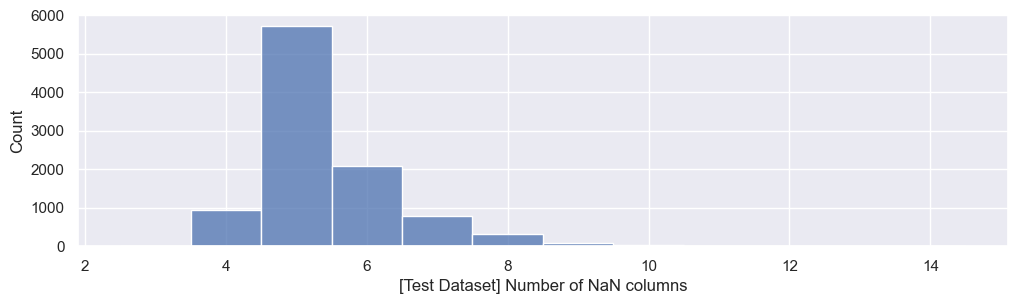

In [4]:
test_df = pd.read_csv(r"./dataset/test.csv")
test_df['model'] = test_df['model'].apply(lambda x:x.replace('(', ''))
test_df['reg_date_dt'] = test_df['reg_date'].apply(lambda x: datetime.strptime(x, "%d-%b-%Y"))
test_df['reg_date_year'] = test_df['reg_date_dt'].apply(lambda x:x.year)
test_df['reg_date_month'] = test_df['reg_date_dt'].apply(lambda x:x.month)

plt.rcParams['figure.figsize'] = (12, 3)
sns.set()

number_nans = test_df.apply(lambda row: sum(map(isnan, row)), axis=1)
sns.histplot(number_nans, discrete=True)
plt.xlabel('[Test Dataset] Number of NaN columns')
plt.show()

### Read and clean dataset

In [5]:
orig_df.accessories.iloc[6]

NameError: name 'orig_df' is not defined

In [ ]:
orig_df[~orig_df.lifespan.isna()]

In [12]:
orig_df = pd.read_csv(r"./dataset/train.csv")

# clean model
orig_df['model'] = orig_df['model'].apply(lambda x:x.replace('(', ''))
orig_df['reg_date_dt'] = orig_df['reg_date'].apply(lambda x: datetime.strptime(x, "%d-%b-%Y"))
orig_df['reg_date_year'] = orig_df['reg_date_dt'].apply(lambda x:x.year)
orig_df['reg_date_month'] = orig_df['reg_date_dt'].apply(lambda x:x.month)

# Adding additional feature for imputation later
# train_df["model_make"] = train_df.model + "_" + train_df.make

General overview of Nan Columns

In [13]:
plt.rcParams['figure.figsize'] = (12, 3)
sns.set()

number_nans = train_df.apply(lambda row: sum(map(isnan, row)), axis=1)
sns.histplot(number_nans, discrete=True)
plt.xlabel('[Train Dataset] Number of NaN columns')
plt.show()

NameError: name 'train_df' is not defined

In [14]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   listing_id         25000 non-null  int64         
 1   title              25000 non-null  object        
 2   make               23684 non-null  object        
 3   model              25000 non-null  object        
 4   description        24320 non-null  object        
 5   manufactured       24993 non-null  float64       
 6   original_reg_date  255 non-null    object        
 7   reg_date           25000 non-null  object        
 8   type_of_vehicle    25000 non-null  object        
 9   category           25000 non-null  object        
 10  transmission       25000 non-null  object        
 11  curb_weight        24693 non-null  float64       
 12  power              22360 non-null  float64       
 13  fuel_type          5879 non-null   object        
 14  engine

In [15]:
## Split into train val split
train_df, val_df = train_test_split(orig_df, test_size=0.2, random_state=42, shuffle=True)

### Fill missing 'make' info from title

In [16]:
make_df = pd.read_csv(r"./dataset/make.csv")
make_ls = [make.lower() for make in make_df['Make List'].unique()]

In [17]:
make_model_imputer = MakeModelImputer(make_ls)

train_df = make_model_imputer.transform(train_df)
val_df = make_model_imputer.transform(val_df) 
test_df = make_model_imputer.transform(test_df) 

In [18]:
# Generating model make imputer
train_df["model_make"] = train_df.model + "_" + train_df.make
val_df["model_make"] = val_df.model + "_" + val_df.make
test_df["model_make"] = test_df.model + "_" + test_df.make

### type_of_vehicle

In [19]:
# For each model and make check the type of vehicles count
unique_list = display_feature_dist_by_ref_col(df=train_df,feature="type_of_vehicle",ref="model_make")
make_models_with_diff_bodies = list()
for key, value in unique_list.items():
    if len(value) >= 2:
        make_models_with_diff_bodies.append(key)

Number of model_make unable to be inputted 0


In [20]:
# Assuming you have a DataFrame 'train_df' with columns 'type_of_vehicle' and 'price'
fig = px.box(train_df, x="type_of_vehicle", y='price', points="all")

# Update the layout to make the x-axis labels horizontal
fig.update_layout(xaxis_tickangle=0)

# Show the figure
fig.show()

In [21]:
# Assuming you have a DataFrame 'train_df' with columns 'type_of_vehicle' and 'price'
fig = px.scatter(train_df, x="omv", y='price', color="type_of_vehicle",trendline="ols")

# Show the figure
fig.show()

In [22]:
## Processing 
train_df , vehicle_type_encoder = vehicle_type_fit_transform(train_df, "type_of_vehicle")
val_df = vehicle_type_fit(val_df, vehicle_type_encoder)
test_df = vehicle_type_fit(test_df, vehicle_type_encoder)

### curb_weight

In [23]:
# Superceeded # display(HTML(train_df.head(50).to_html()))
def fill_column_b_with_mean(df, column_a, column_b):
    # Calculate the mean of column B grouped by column A
    values = df.groupby(column_a)[column_b].agg(["mean"]).rename(columns={"mean": column_b})[column_b]
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # If column B is NaN, fill it with the mean value of column B for the corresponding value in column A
        if pd.isna(row[column_b]):
            df.at[index, column_b] = values[row[column_a]]
    return df

In [24]:
curb_weight_impute = ModelMakeImputer(column_a="model_make", column_b="curb_weight")

train_df = curb_weight_impute.fit_transform(train_df) # 82 rows missing
val_df = curb_weight_impute.transform(val_df) # 20 rows missing
test_df = curb_weight_impute.transform(test_df) # 40 rows missing

In [25]:
# Many rows are missing, impute using median values
imputer = SimpleImputer(strategy='median')
train_df['curb_weight'] = imputer.fit_transform(train_df[['curb_weight']])
val_df['curb_weight'] = imputer.transform(val_df[['curb_weight']])
test_df['curb_weight'] = imputer.transform(test_df[['curb_weight']])

### power 

In [26]:
power_impute = ModelMakeImputer(column_a="model_make", column_b="power")

train_df = power_impute.fit_transform(train_df) # 1537 rows missing
val_df = power_impute.transform(val_df) # 379 rows missing
test_df = power_impute.transform(test_df) # 789 rows missing

In [27]:
# Many rows are missing, impute using median values
imputer = SimpleImputer(strategy='median')
train_df['power'] = imputer.fit_transform(train_df[['power']])
val_df['power'] = imputer.transform(val_df[['power']])
test_df['power'] = imputer.transform(test_df[['power']])

### engine_cap 

In [28]:
engine_impute = ModelMakeImputer(column_a="model_make", column_b="engine_cap")

train_df = engine_impute.fit_transform(train_df) # 384 rows missing
val_df = engine_impute.transform(val_df) # 97 rows missing
test_df = engine_impute.transform(test_df) # 186 rows missing

In [29]:
# Many rows are missing, impute using median values
imputer = SimpleImputer(strategy='median')
train_df['engine_cap'] = imputer.fit_transform(train_df[['engine_cap']])
val_df['engine_cap'] = imputer.transform(val_df[['engine_cap']])
test_df['engine_cap'] = imputer.transform(test_df[['engine_cap']])

### no_of_owners

In [30]:
# display(f' Before imputation : {train_df["no_of_owners"].isna().sum()}')
# # Original Code Output
# rows = train_df[train_df["no_of_owners"].isna()].index

# for r in rows:
#     row = train_df.iloc[r]

#     #Impute number of owners based on reg_date
#     regDate = row["reg_date"]
#     months = calculate_date_diff(regDate)

#     # We estimate the number of owners based on every 3 years or 36 months
#     estimated_owners = math.ceil(months / 36)
#     train_df.loc[r, "no_of_owners"] = estimated_owners

# display(f' After imputation : {train_df["no_of_owners"].isna().sum()}')

In [86]:
# display(f' Before imputation : {train_df["no_of_owners"].isna().sum()}')
# # Function form
# train_df = impute_owner_number(train_df)

# display(f' After imputation : {train_df["no_of_owners"].isna().sum()}')

In [87]:
train_df.reg_date.isna().sum()

0

In [88]:
## New method
display(f' Before imputation : {train_df["no_of_owners"].isna().sum()}')

owner_impute = OwnerImputer()

train_df = owner_impute.fit_transform(df=train_df)
val_df = owner_impute.transform(val_df)
test_df = owner_impute.transform(test_df)
display(f' After imputation : {train_df["no_of_owners"].isna().sum()}')

' Before imputation : 0'

20000


C:\Users\kan_h\Desktop\Kan Hon\Admin\NUS MComp\AY2425_Sem1\CS5228\cs5228-project\CS5228_project\utils\eda.py:45: RuntimeWarning:

divide by zero encountered in scalar divide



[Number of months per owner]  ->  [mean = inf, median = 529.1514755565718, mode = 1037.4713560106268]


' After imputation : 0'

In [34]:
test_df.no_of_owners.isna().sum()

0

### Manufactured

In [35]:
# Manufactured

train_df['effective_reg_date'] = train_df['original_reg_date'].fillna(train_df['reg_date'])
train_df = train_df.drop(columns=['original_reg_date'])

train_df['effective_reg_date'] = pd.to_datetime(train_df['effective_reg_date'], errors='coerce', format='%d-%b-%Y')
train_df['manufactured'] = train_df['manufactured'].fillna(train_df['effective_reg_date'].dt.year)

### depreciation 

In [36]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 45 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   listing_id                       20000 non-null  int64         
 1   title                            20000 non-null  object        
 2   make                             20000 non-null  object        
 3   model                            20000 non-null  object        
 4   description                      19459 non-null  object        
 5   manufactured                     20000 non-null  float64       
 6   reg_date                         20000 non-null  object        
 7   type_of_vehicle                  20000 non-null  object        
 8   category                         20000 non-null  object        
 9   transmission                     20000 non-null  object        
 10  curb_weight                      20000 non-null  float64  

In [37]:
dep_imputer = DepreciationImputer()

train_df = dep_imputer.fit_transform(X=train_df)
val_df = dep_imputer.transform(X=val_df)
test_df = dep_imputer.transform(X=test_df)

### Transmission

In [38]:
# Transmission

# One-hot encoding
train_df = pd.get_dummies(train_df, columns=['transmission'], prefix='transmission')
train_df.drop('transmission_manual', axis=1, inplace=True)

unique_transmissions = train_df['transmission_auto'].unique()
transmission_counts = train_df['transmission_auto'].value_counts()
print(unique_transmissions, transmission_counts)

[ True False] transmission_auto
True     18660
False     1340
Name: count, dtype: int64


### dereg_value

### mileage   

In [42]:
# display(f' Before imputation : {train_df["mileage"].isna().sum()}')
# # Original Code Output
# rows = train_df[train_df["mileage"].isna()].index
# for r in rows:
#     row = train_df.iloc[r]
#     #print(f"row: {row}")
#     regDate = row["reg_date"]
#     months = calculate_date_diff(regDate)

#     #impute mileage based on reg_date 
#     #we estimate that the average mileage of a car is 8000 miles per year
#     estimated_mileage = months / 12 * 8000
#     train_df.loc[r, "mileage"] = estimated_mileage

# display(f' After imputation : {train_df["mileage"].isna().sum()}')

' Before imputation : 4248'

NameError: name 'calculate_date_diff' is not defined

In [43]:
display(f' Before imputation : {train_df["mileage"].isna().sum()}')
## New method

mileage_impute = mileageImputer()

train_df = mileage_impute.fit_transform(df=train_df)
val_df = mileage_impute.transform(val_df)
test_df = mileage_impute.transform(test_df)

display(f' After imputation : {train_df["mileage"].isna().sum()}')

' Before imputation : 4248'

[Miles per month]  ->  [mean = 1008.1117259874483, median = 979.3646346929628, mode = 1000.0]


' After imputation : 0'

### omv 

In [44]:
csv_filename = r'./dataset/lta_omv_data.csv'

if os.path.exists(csv_filename):
    df_lta_car_data = pd.read_csv(csv_filename)
else:
    result_ls = get_lta_omv_data(2002, 2025)
    df_lta_car_data = preprocess_lta_omv_data(result_ls)
    df_lta_car_data.to_csv(csv_filename)

lta_data_imputer = LTADataImputer(df_lta_car_data)

train_df = lta_data_imputer.transform(train_df) # before transform: 49 rows missing, after transform: 24 rows missing
val_df = lta_data_imputer.transform(val_df) # before transform: 15 rows missing, after transform: 9 rows missing
test_df = lta_data_imputer.transform(test_df) 

imputer = SimpleImputer(strategy='median')
train_df['omv'] = imputer.fit_transform(train_df[['omv']])
val_df['omv'] = imputer.transform(val_df[['omv']])
test_df['omv'] = imputer.transform(test_df[['omv']])

In [45]:
# Superceeded code
def impute_using_lta_data(row):
    # print(row)
    if not np.isnan(row['omv']):
        return row['omv']
    else:
        make = row['make']
        model = row['model']
        year = row['reg_date_year']
        lookup_by_make_model_year = df_lta_car_data[(df_lta_car_data['make_clean'] == make) & (df_lta_car_data['model_split'].str.contains(model)) & (df_lta_car_data['year'] == year)]
        
        lookup_by_make_model = df_lta_car_data[(df_lta_car_data['make_clean'] == make) & (df_lta_car_data['model_split'].str.contains(model))]

        lookup_by_make = df_lta_car_data[(df_lta_car_data['make_clean'] == make)]
        
        if not lookup_by_make_model_year.empty:
            # print('lookup_by_make_model_year')
            return lookup_by_make_model_year['omv_clean'].mean()
        elif not lookup_by_make_model.empty:
            # print('lookup_by_make_model')
            return lookup_by_make_model['omv_clean'].mean()
        elif not lookup_by_make.empty:
            # print('lookup_by_make')
            return lookup_by_make['omv_clean'].mean()
        else: 
            return None

# train_df['omv_new'] = train_df['omv']
# train_df['omv_new'] = train_df.apply(impute_using_lta_data, axis=1)
# train_df['omv_new'] = train_df['omv_new'].fillna(train_df['omv_new'].mean())

# train_df.info()

### Lifespan

In [46]:
# display(f' Before imputation : {train_df["lifespan"].isna().sum()}')

# # Functional Form
# impute_lifespan(train_df)

# display(f' After imputation : {train_df["lifespan"].isna().sum()}')

' Before imputation : 18138'

NameError: name 'impute_lifespan' is not defined

### Fuel Type

In [48]:
# Assuming you have a DataFrame 'train_df' with columns 'type_of_vehicle' and 'price'
fig = px.box(train_df, x="fuel_type", y='price', points="all")

# Update the layout to make the x-axis labels horizontal
fig.update_layout(xaxis_tickangle=0)

# Show the figure
fig.show()

In [49]:
get_fuel_type(train_df)

Original Imputation Nan 14397
After Imputation Nan 14397


,listing_id,title,make,model,description,manufactured,reg_date,type_of_vehicle,category,curb_weight,...,type_of_vehicle_mpv,type_of_vehicle_others,type_of_vehicle_sports car,type_of_vehicle_stationwagon,type_of_vehicle_suv,type_of_vehicle_truck,type_of_vehicle_van,effective_reg_date,car_age,transmission_auto
0,1260733,Isuzu NPR85,isuzu,npr85,cheapest in the market! 14 feet full canopy wi...,2019.0,01-jul-2020,truck,premium ad car,2500.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2020-07-01,5.0,True
1,1289505,Honda Fit 1.3A G (COE till 06/2024),honda,fit,200,2009.0,12-aug-2009,hatchback,coe car,1010.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2009-08-12,15.0,True
2,1316182,Toyota Sienta 1.5A,toyota,sienta,non phv. excellent condition. 100% accident fr...,2018.0,28-may-2018,mpv,"parf car, premium ad car",1325.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-05-28,6.0,True
3,1310514,Volvo V40 T4 Momentum,volvo,v40,"well maintained! the safety, reliable and dura...",2018.0,30-aug-2019,hatchback,parf car,1441.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-08-30,6.0,True
4,1247893,Kia Carens 2.0A GDI,kia,carens,rare 1 owner unit! low km done! fully maintain...,2015.0,18-nov-2015,mpv,parf car,1544.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-11-18,9.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1330095,BMW 3 Series 318i,bmw,318i,0,2015.0,26-feb-2016,luxury sedan,"parf car, consignment car, sgcarmart warranty ...",1425.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-02-26,9.0,True
19996,1300273,Nissan Qashqai 1.2A DIG-T,nissan,qashqai,"no repairs needed, buy and drive as it is! one...",2016.0,17-jun-2016,suv,"parf car, premium ad car",1285.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2016-06-17,8.0,True
19997,1316903,Honda Jazz 1.3A,honda,jazz,"1 owner, maintain by honda kah motor, at dicks...",2019.0,10-jul-2019,hatchback,parf car,1052.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-07-10,5.0,True
19998,1329593,Ferrari 488 GTB,ferrari,488,ital unit with warranty till dec 2024. fully s...,2016.0,03-nov-2016,sports car,"parf car, direct owner sale, rare & exotic, lo...",1515.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2016-11-03,8.0,True


### Cylinder Count

In [50]:
cylinder_count_extractor = CylinderExtractor()

train_df = cylinder_count_extractor.transform(train_df)
val_df = cylinder_count_extractor.transform(val_df) 
test_df = cylinder_count_extractor.transform(test_df) 

In [51]:
cylinder_imputer = CylinderImputer()
train_df = cylinder_imputer.fit_transform(train_df) # 1479 rows missing
val_df = cylinder_imputer.transform(val_df) # 334 rows missing
test_df = cylinder_imputer.transform(test_df)

# Many rows are missing, impute using median values
imputer = SimpleImputer(strategy='median')
train_df['cylinder_cnt'] = imputer.fit_transform(train_df[['cylinder_cnt']])
val_df['cylinder_cnt'] = imputer.transform(val_df[['cylinder_cnt']])
test_df['cylinder_cnt'] = imputer.transform(test_df[['cylinder_cnt']])

### Category Parser

In [52]:
category_parser = CategoryParser()
train_df = category_parser.fit_transform(train_df) 
val_df = category_parser.transform(val_df) 

In [53]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 63 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   listing_id                       20000 non-null  int64         
 1   title                            20000 non-null  object        
 2   make                             20000 non-null  object        
 3   model                            20000 non-null  object        
 4   description                      19459 non-null  object        
 5   manufactured                     20000 non-null  float64       
 6   reg_date                         20000 non-null  object        
 7   type_of_vehicle                  20000 non-null  object        
 8   category                         20000 non-null  object        
 9   curb_weight                      20000 non-null  float64       
 10  power                            20000 non-null  float64  

### features 

In [54]:
train_df['cylinder_cnt'] = train_df['features'].apply(lambda x: extract_cylinder_from_features(x) if pd.notnull(x) else None)
cylinder_count_dict = extract_cylinder_by_model_make(train_df)
train_df['cylinder_cnt'] = train_df.apply(lambda x:impute_row_by_make_model(x, cylinder_count_dict, 'cylinder_cnt'), axis=1)
# fill remaining values with median of 4 cylinder (most common engine)
median_cylinder_cnt = train_df['cylinder_cnt'].median(axis=0)
train_df['cylinder_cnt'] = train_df['cylinder_cnt'].fillna(median_cylinder_cnt)

In [55]:
train_df.columns

Index(['listing_id', 'title', 'make', 'model', 'description', 'manufactured',
       'reg_date', 'type_of_vehicle', 'category', 'curb_weight', 'power',
       'fuel_type', 'engine_cap', 'no_of_owners', 'depreciation', 'coe',
       'road_tax', 'dereg_value', 'mileage', 'omv', 'arf', 'opc_scheme',
       'lifespan', 'eco_category', 'features', 'accessories',
       'indicative_price', 'price', 'reg_date_dt', 'reg_date_year',
       'reg_date_month', 'model_make', 'type_of_vehicle_bus/mini bus',
       'type_of_vehicle_hatchback', 'type_of_vehicle_luxury sedan',
       'type_of_vehicle_mid-sized sedan', 'type_of_vehicle_mpv',
       'type_of_vehicle_others', 'type_of_vehicle_sports car',
       'type_of_vehicle_stationwagon', 'type_of_vehicle_suv',
       'type_of_vehicle_truck', 'type_of_vehicle_van', 'effective_reg_date',
       'car_age', 'transmission_auto', 'cylinder_cnt', '-', 'almost new car',
       'coe car', 'consignment car', 'direct owner sale', 'electric cars',
       'hybri

## Data normalization

In [56]:
display(HTML(train_df.head(5).to_html()))

,listing_id,title,make,model,description,manufactured,reg_date,type_of_vehicle,category,curb_weight,power,fuel_type,engine_cap,no_of_owners,depreciation,coe,road_tax,dereg_value,mileage,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price,price,reg_date_dt,reg_date_year,reg_date_month,model_make,type_of_vehicle_bus/mini bus,type_of_vehicle_hatchback,type_of_vehicle_luxury sedan,type_of_vehicle_mid-sized sedan,type_of_vehicle_mpv,type_of_vehicle_others,type_of_vehicle_sports car,type_of_vehicle_stationwagon,type_of_vehicle_suv,type_of_vehicle_truck,type_of_vehicle_van,effective_reg_date,car_age,transmission_auto,cylinder_cnt,-,almost new car,coe car,consignment car,direct owner sale,electric cars,hybrid cars,imported used vehicle,low mileage car,opc car,parf car,premium ad car,rare & exotic,sgcarmart warranty cars,sta evaluated car,vintage cars
0,1260733,Isuzu NPR85,isuzu,npr85,cheapest in the market! 14 feet full canopy with wooden body! class 3 can drive! excellent condition with original upholstery! servicing provided! premium warranty provided! 100% loan available! trade in are welcomed! contact our friendly sales consultant now!,2019.0,01-jul-2020,truck,premium ad car,2500.0,110.0,diesel,2999.0,2.0,14860.0,22085,NaN,13348.0,51413.698025,37994.0,1900.0,NaN,30-jun-2040,uncategorized,view specs of the isuzu n series diesel,NaN,NaN,89800.0,2020-07-01,2020,7,npr85_isuzu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2020-07-01,5.0,True,4.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1289505,Honda Fit 1.3A G (COE till 06/2024),honda,fit,200,2009.0,12-aug-2009,hatchback,coe car,1010.0,73.0,NaN,1339.0,5.0,11630.0,14920,885.0,123.0,183476.334130,14211.0,14211.0,NaN,NaN,uncategorized,view specs of the honda fit,NaN,NaN,700.0,2009-08-12,2009,8,fit_honda,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2009-08-12,15.0,True,4.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1316182,Toyota Sienta 1.5A,toyota,sienta,"non phv. excellent condition. 100% accident free. sta evaluation welcome. highest trade in. standard/high bank loan, balloon loan, in house loan. 100% loan available. 1 day loan approval. test drive today",2018.0,28-may-2018,mpv,"parf car, premium ad car",1325.0,79.0,NaN,1496.0,2.0,14530.0,38001,682.0,25880.0,80346.000000,17199.0,17199.0,NaN,NaN,uncategorized,"1.5l dohc 16v vvt-i engine, 7 speed cvt-i auto transmission, 2 x airbags, abs, auto headlights, power sliding door, knockdown rear seats, rear aircon. view specs of the toyota sienta","factory touchscreen audio system with reverse camera, like new leather seats, parking sensors.",NaN,64800.0,2018-05-28,2018,5,sienta_toyota,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-05-28,6.0,True,4.0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
3,1310514,Volvo V40 T4 Momentum,volvo,v40,"well maintained! the safety, reliable and durable branding! flexible loan packages available! high loan with no admin charges! insurance assistance and trade in welcomed! call our friendly sales consultant now for viewing/test drive!",2018.0,30-aug-2019,hatchback,parf car,1441.0,140.0,NaN,1969.0,1.0,15770.0,36901,1176.0,35358.0,68000.000000,22799.0,23919.0,NaN,NaN,uncategorized,"powerful 2.0l 4 cylinder inline 16 valve turbocharged engine, 8 speed automatic transmission. 187bhp, 300nm. view specs of the volvo v40","keyless entry/start, cruise control, auto headlights, collision warning system.",NaN,92800.0,2019-08-30,2019,8,v40_volvo,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-08-30,6.0,True,4.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1247893,Kia Carens 2.0A GDI,kia,carens,rare 1 owner unit! low km done! fully maintained & serviced by c&c till 2022! guaranteed not use for phv! well maintained and taken by previous owner! spacious 7 seater that can fit all passengers comfortably! great short term mpv for daily use! call now to find out more!,2015.0,18-nov-2015,mpv,parf car,1544.0,122.0,NaN,1999.0,1.0,15540.0,58190,1212.0,20117.0,130000.000000,21074.0,21504.0,NaN,NaN,uncategorized,view specs of the kia carens,"upgrade

In [61]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from utils.models import Regression
from sklearn.impute import SimpleImputer


In [64]:

features = ['cylinder_cnt', 
       'depreciation', 'mileage', 'dereg_value']

X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df['price'], test_size=0.3, random_state=42)


In [65]:
scaler = MinMaxScaler()
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train[features])

X_train[features] = imputer.transform(X_train[features])
X_test[features] = imputer.transform(X_test[features])

# Fit and transform the numerical columns
X_train[features] = scaler.fit_transform(X_train[features])
X_test[features] = scaler.transform(X_test[features])

In [66]:
X_train[features].info()

<class 'pandas.core.frame.DataFrame'>
Index: 14000 entries, 17218 to 15795
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cylinder_cnt  14000 non-null  float64
 1   depreciation  14000 non-null  float64
 2   mileage       14000 non-null  float64
 3   dereg_value   14000 non-null  float64
dtypes: float64(4)
memory usage: 546.9 KB


## Training models

In [67]:
train_df.lifespan

0        30-jun-2040
1                NaN
2                NaN
3                NaN
4                NaN
            ...     
19995            NaN
19996            NaN
19997            NaN
19998            NaN
19999            NaN
Name: lifespan, Length: 20000, dtype: object

In [68]:
# display(HTML(train_df.head(50).to_html()))
features = ['curb_weight', 'power', 'cylinder_cnt', 'omv',
       'engine_cap', 'depreciation', 'mileage', 'no_of_owners','type_of_vehicle_bus/mini bus', 'type_of_vehicle_hatchback',
       'type_of_vehicle_luxury sedan', 'type_of_vehicle_mid-sized sedan',
       'type_of_vehicle_mpv', 'type_of_vehicle_others',
       'type_of_vehicle_sports car', 'type_of_vehicle_stationwagon',
       'type_of_vehicle_suv', 'type_of_vehicle_truck', 'type_of_vehicle_van']

train_df[features].isna().sum()

curb_weight                         0
power                               0
cylinder_cnt                        0
omv                                 0
engine_cap                          0
depreciation                       96
mileage                             0
no_of_owners                        0
type_of_vehicle_bus/mini bus        0
type_of_vehicle_hatchback           0
type_of_vehicle_luxury sedan        0
type_of_vehicle_mid-sized sedan     0
type_of_vehicle_mpv                 0
type_of_vehicle_others              0
type_of_vehicle_sports car          0
type_of_vehicle_stationwagon        0
type_of_vehicle_suv                 0
type_of_vehicle_truck               0
type_of_vehicle_van                 0
dtype: int64

In [69]:
# Scale dataset
scaler = MinMaxScaler()
imputer = SimpleImputer(strategy='median')

imputer.fit(train_df[features])

# Split data into training and test sets
train_df[features] = imputer.transform(train_df[features])
val_df[features] = imputer.transform(val_df[features])
test_df[features] = imputer.transform(test_df[features])

# Fit and transform the numerical columns
train_df[features] = scaler.fit_transform(train_df[features])
val_df[features] = scaler.transform(val_df[features])
test_df[features] = scaler.transform(test_df[features])

In [70]:
X_train = train_df[features]
y_train = train_df['price']

X_val = val_df[features]
y_val = val_df['price']

In [71]:
# 2. Initialize the Regression class
regressor = Regression()

# 3. Define parameters for hyperparameter tuning
params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [ 1, 10, 20],
    'min_samples_split': [2, 5, 10]
}


# Example for Random Forest with accuracy scoring and KFold validation
tuner, best_params, tuner_results = regressor.hyperparameter_tuning(
    df_tuple=(X_train, y_train),   # The training data (X, y)
    score_metric='neg_root_mean_squared_error',       # Scoring metric
    kfold_type='kfold',            # Type of fold (KFold used here)
    n_splits=5,                    # Number of splits for KFold
    params=params,                 # Hyperparameter grid to search
    model_name='random_forest'      # Model to use (Random Forest in this case)
)

# 4. View the best hyperparameters and fit the model
print(f"Best Parameters: {best_params}")

# 5. Use the best model to predict on the test set
best_model = tuner.best_estimator_


Model Tuning Starttime :: 2024-10-31 10:14:49.678436
Model Tuning Completed :: 2024-10-31 10:15:47.009699
Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50}


In [72]:
import joblib

# Save model 
model_name = "random_forest_v3"
save_path = f"./model_assets"
# Save the trained model
joblib.dump(best_model, f"{save_path}/{model_name}.joblib")

['./model_assets/random_forest_v3.joblib']

In [73]:
import joblib
import plotly.express as px
import plotly.graph_objects as go

def _infer_type(data) -> np.ndarray:

    ## type checker

    try:
        assert type(data) == np.ndarray, "incorrect type"

    except AssertionError:
        data = data.to_numpy()
        print("INFO [_infer_type] :: Type changed")
        return data

    else:
        return data

def mini_reg_evaluate(
    df_train_tuple: tuple, df_valid_tuple: tuple, model_name: str, save_path:str
):

    model = joblib.load(f"{save_path}/{model_name}.joblib")
    X_train, y_train = df_train_tuple[0], df_train_tuple[1]
    X_valid, y_valid = df_valid_tuple[0], df_valid_tuple[1]

    ## type checker

    X_train = _infer_type(X_train)
    y_train = _infer_type(y_train)
    X_valid = _infer_type(X_valid)
    y_valid = _infer_type(y_valid)

    # Train and validation scores
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    
    # Visualize scatter plot for validation data
    plt.scatter(y_valid, y_valid_pred, color='blue', alpha=0.5)
    plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], color='red', linestyle='--')
    plt.title("y_valid predicted vs actual")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
    
    # Visualize scatter plot for training data
    plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
    plt.title("y_train predicted vs actual")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
    
    # Visualize residual plot
    plt.scatter(y_valid_pred, y_valid_pred - y_valid, color='blue', alpha=0.5)
    plt.plot([y_valid_pred.min(), y_valid_pred.max()], [0, 0], color='red', linestyle='--')
    plt.title("Residual Plot (Validation Data)")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residual Values")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
    
    plt.scatter(y_train_pred, y_train_pred - y_train, color='blue', alpha=0.5)
    plt.plot([y_train_pred.min(), y_train_pred.max()], [0, 0], color='red', linestyle='--')
    plt.title("Residual Plot (Training Data)")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residual Values")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
  

INFO [_infer_type] :: Type changed
INFO [_infer_type] :: Type changed
INFO [_infer_type] :: Type changed
INFO [_infer_type] :: Type changed


C:\Users\kan_h\.conda\envs\cs5228\lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

C:\Users\kan_h\.conda\envs\cs5228\lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



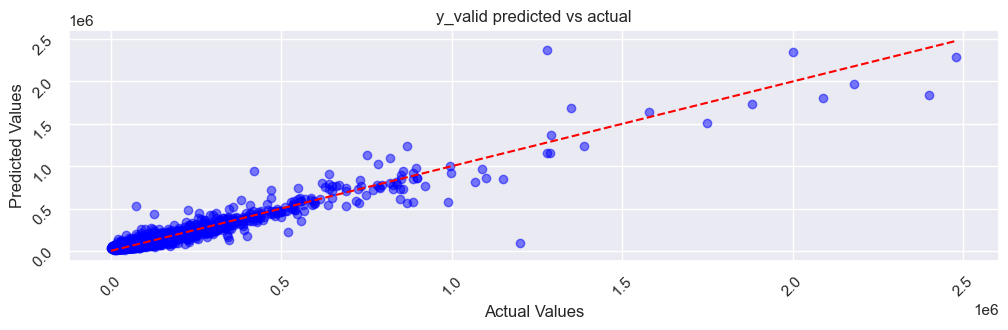

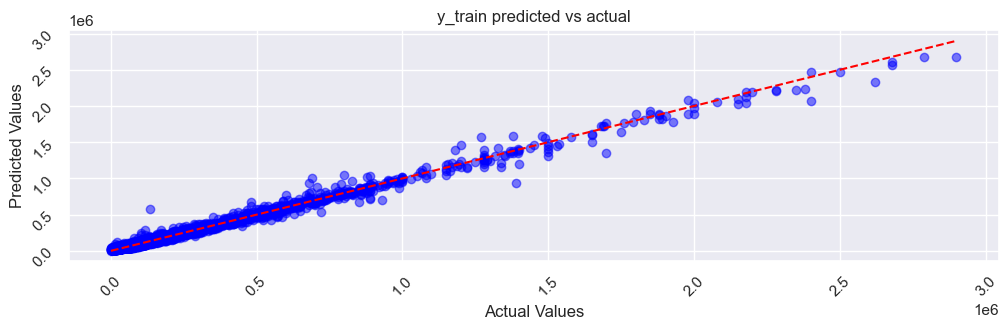

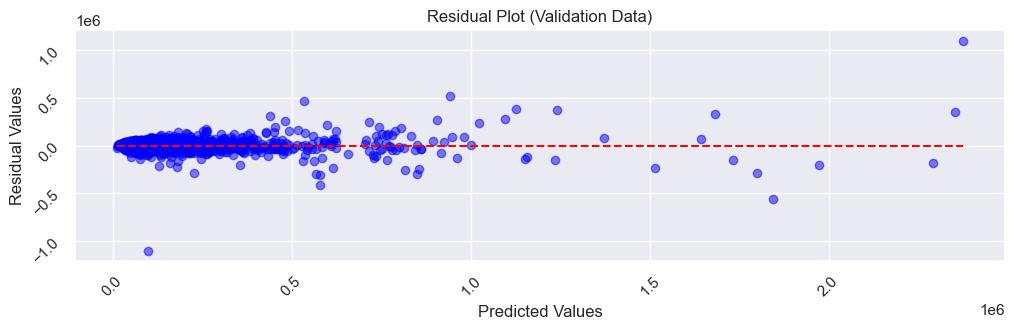

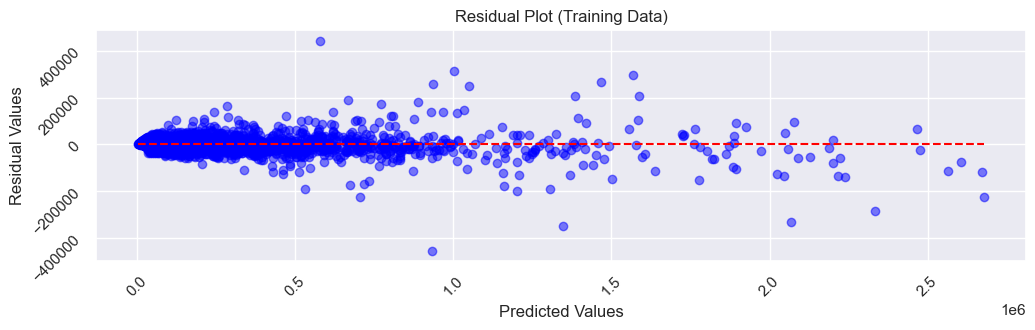

In [74]:
model_name = "random_forest_v3"
save_path = f"./model_assets"

mini_reg_evaluate(df_train_tuple=(X_train, y_train),
df_valid_tuple=( X_val,y_val),model_name=model_name, save_path=save_path)

In [75]:
## Retrain the model
# Train + Valid (Retrain on the whole model)

In [76]:
model = joblib.load(f"{save_path}/{model_name}.joblib")
X_test = _infer_type(test_df[features])
y_test_pred = model.predict(X_test)
submission = pd.DataFrame(y_test_pred).reset_index().rename(columns={"index":"Id", 0:"Predicted"})
submission.to_csv("submission/submission_rf_2.csv")

INFO [_infer_type] :: Type changed


C:\Users\kan_h\.conda\envs\cs5228\lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



### SHAP analysis

In [77]:
import shap


C:\Users\kan_h\.conda\envs\cs5228\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [78]:
explainer = shap.Explainer(best_model)


In [82]:
test_df

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,type_of_vehicle_mid-sized sedan,type_of_vehicle_mpv,type_of_vehicle_others,type_of_vehicle_sports car,type_of_vehicle_stationwagon,type_of_vehicle_suv,type_of_vehicle_truck,type_of_vehicle_van,car_age,cylinder_cnt
0,1303772,Honda Vezel 1.5A X,honda,vezel,4614,2015.0,NaN,29-apr-2015,suv,parf car,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.0,0.272727
1,1323166,Mazda 3 1.6A SP (COE till 10/2027),mazda,3,extremely well maintained and in pristine cond...,2007.0,NaN,26-oct-2007,mid-sized sedan,"coe car, premium ad car, low mileage car",...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.272727
2,1308405,MINI Cooper S Countryman 2.0A,mini,cooper,1 owner! beautiful island blue color! eurokars...,2019.0,NaN,27-mar-2020,sports car,parf car,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,0.272727
3,1216706,Toyota Vios 1.5A G,toyota,vios,fully agent maintain! genuine low mileage at 5...,2019.0,NaN,28-jun-2019,mid-sized sedan,"parf car, premium ad car",...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.272727
4,1298206,Mazda 3 HB 1.5A,mazda,3,workshop check/sta evaluation available. accid...,2015.0,NaN,19-nov-2015,hatchback,"parf car, premium ad car",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.272727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1315765,MG HS 1.5A Turbo,mg,hs,stylish and fuel-efficient drive at an afford...,2020.0,NaN,30-nov-2020,suv,parf car,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.272727
9996,1267725,Mercedes-Benz GLA-Class GLA180 Progressive,mercedes-benz,gla180,1 owner and low mileage. comes with agent warr...,2022.0,NaN,21-feb-2023,suv,"parf car, premium ad car, low mileage car",...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.272727
9997,1174990,BMW 3 Series 320i Convertible (COE till 09/2030),bmw,320,"just install koni shocks, for the best road ha...",2010.0,NaN,17-dec-2010,sports car,coe car,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,14.0,0.272727
9998,1221623,Kia Cerato 1.6A EX,kia,cerato,"at dickson, we don't just sell cars, we sell t...",2019.0,NaN,02-mar-2020,mid-sized sedan,parf car,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.272727


In [79]:
shap_values = explainer.shap_values(X_test)



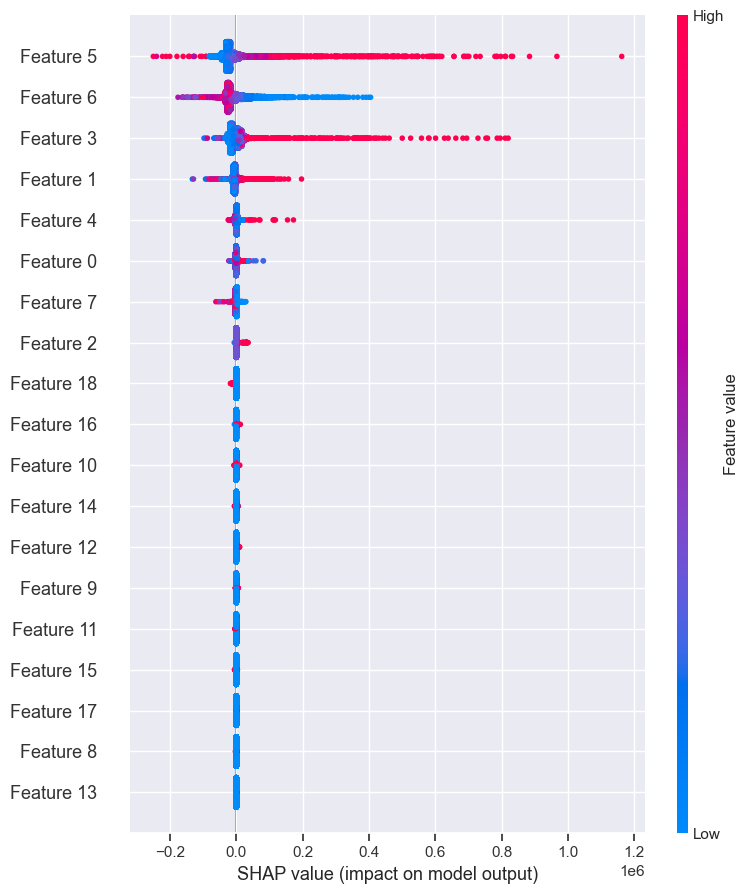

In [80]:
shap.summary_plot(shap_values, X_test)



In [83]:
shap_values = explainer.shap_values(test_df[features])


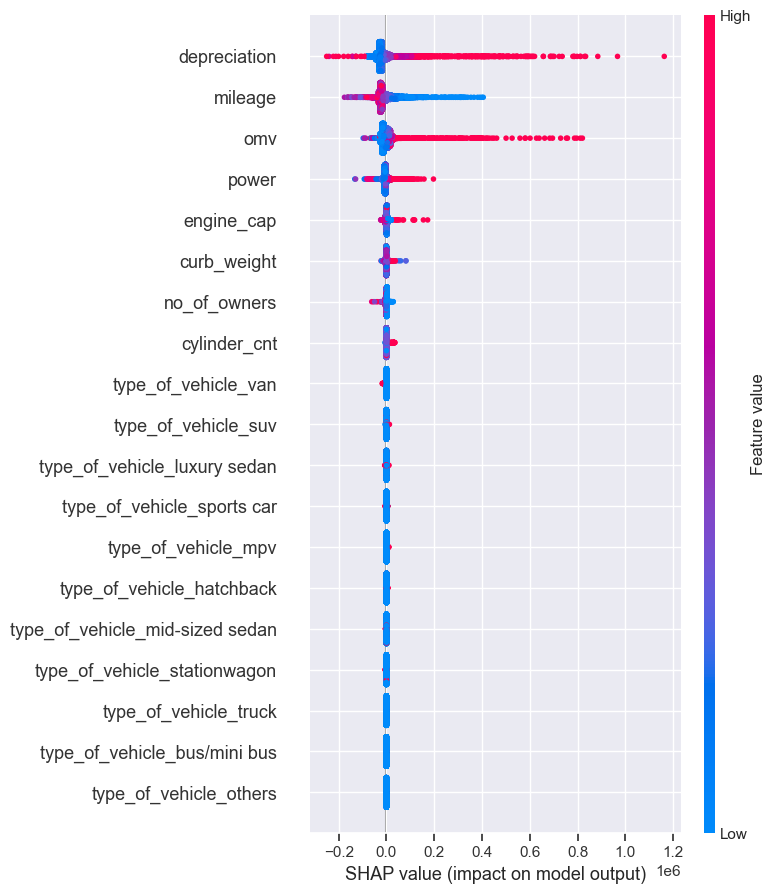

In [85]:
shap.summary_plot(shap_values, test_df[features])
